<a href="https://colab.research.google.com/github/iampro3/YOLOv5/blob/main/Train_YOLOv5_with_Pascal_VOC_in_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

이 노트북은 Colab에서 YOLOv5s 모델을 VOC dataset으로 훈련하는 예제입니다.


PASCAL VOC Dataset을 다운로드 받은 후 압축을 풀어줍니다.

In [3]:
!wget http://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar
!tar -xf VOCtrainval_11-May-2012.tar
!rm VOCtrainval_11-May-2012.tar

--2023-12-06 07:26:28--  http://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar [following]
--2023-12-06 07:26:28--  https://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/octet-stream]
Saving to: ‘VOCtrainval_11-May-2012.tar’

VOCtrainval_11-May- 100%[===================>]   1.86G  27.6MB/s    in 1m 49s  

2023-12-06 07:28:18 (17.5 MB/s) - ‘VOCtrainval_11-May-2012.tar’ saved [1999639040/1999639040]



실습하고 있는 데이터셋은 라벨링이 xml 파일 포맷으로 제공되며, 해당 포맷은 YOLOv5을 활용해 객체 인식 신경망을 훈련할 때 사용할 수 있는 파일 포맷이 아닙니다.

convert2Yolo라고 하는 깃허브 저장소에서 Pascal VOC 데이터셋의 xml 파일 형태를 YOLOv5를 통한 훈련에 사용할 수 있도록 변환하는 기능을 제공합니다. 이를 활용해 xml 파일 포맷을 txt 파일 포맷으로 변환하겠습니다.

이 과정에 앞서 다음과 같이 Pascal VOC 데이터셋의 클래스 리스트가 있는 파일을 생성합니다.

In [4]:
classes = ["aeroplane\n", "bicycle\n", "bird\n", "boat\n", "bottle\n",
           "bus\n", "car\n", "cat\n", "chair\n", "cow\n", "diningtable\n",
           "dog\n", "horse\n", "motorbike\n", "person\n", "pottedplant\n",
           "sheep\n", "sofa\n", "train\n", "tvmonitor"]
with open("vocnames.txt", 'w') as f:
    f.writelines(classes)

vocnames.txt 파일이 생성된 것을 확인한 후 다음과 같이 VOCdevkit/VOC2012 폴더 아래에 labels 폴더를 생성한 후 convert2Yolo 저장소를 활용해 xml 파일을 txt 파일로 변환합니다

In [5]:
!git clone https://github.com/ssaru/convert2Yolo.git
!cd convert2Yolo && python3 example.py --datasets VOC \
--img_path ../VOCdevkit/VOC2012/JPEGImages/ \
--label ../VOCdevkit/VOC2012/Annotations/ \
--convert_output_path ../VOCdevkit/VOC2012/JPEGImages/ \
--img_type ".jpg" \
--manifest_path ../ \
--cls_list_file ../vocnames.txt

Cloning into 'convert2Yolo'...
remote: Enumerating objects: 215, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 215 (delta 38), reused 35 (delta 35), pack-reused 172
Receiving objects: 100% (215/215), 994.67 KiB | 3.09 MiB/s, done.
Resolving deltas: 100% (95/95), done.

VOC Parsing:   |████████████████████████████████████████| 100.0% (17125/17125)  Complete


YOLO Generating:|████████████████████████████████████████| 100.0% (17125/17125)  Complete


YOLO Saving:   |████████████████████████████████████████| 100.0% (17125/17125)  Complete



다운로드 완료 후 훈련을 위한 이미지가 있는 폴더의 경로는 아래와 같습니다.

/content/VOCdevkit/VOC2012/JPEGImages/

YOLOv5를 통한 객체 인식 신경망을 훈련하기 위해 각 이미지 내 객체의 위치가 라벨링되어 있는 텍스트 파일은 이미지와 같은 폴더에 있습니다.

YOLOv5에서 훈련할 때 이미지와 같은 경로에 이미지와 동일한 이름의 라벨링 된 텍스트 파일이 있어야만 훈련을 수행할 수 있습니다. 구체적인 파일 구조는 아래와 같습니다.


```
$Object_Detection_Dataset/
                         ┗ 1.png
                         ┗ 1.txt
                         ┗ 2.jpg
                         ┗ 2.txt

```

이제 데이터를 훈련 데이터와 검증 데이터로 나누겠습니다.

In [6]:
import os
import shutil
from tqdm import tqdm
data_root = "/content/VOCData"
val_root = os.path.join(data_root, "val")
train_root = os.path.join(data_root, "train")
os.makedirs(val_root, exist_ok=True)
os.makedirs(train_root, exist_ok=True)

with open("/content/manifest.txt") as f:
    files = f.readlines()

for idx, img_path in tqdm(enumerate(files)):
    img_src = img_path.split('\n')[0]
    txt_src = os.path.splitext(img_src)[0] + ".txt"
    img_name = os.path.split(img_src)[-1]
    text_name = os.path.split(txt_src)[-1]
    if idx % 10 < 3:
        img_dst = os.path.join(val_root, img_name)
        text_dst = os.path.join(val_root, text_name)
    else:
        img_dst = os.path.join(train_root, img_name)
        text_dst = os.path.join(train_root, text_name)
    shutil.copy2(img_src, img_dst)
    shutil.copy2(txt_src, text_dst)

17125it [00:04, 3457.31it/s]


이제 YOLOv5를 VOC dataset으로 훈련하도록 하겠습니다.

학습을 위해 YOLOv5 환경을 구성하도록 하겠습니다.

In [7]:
!git clone -b v7.0 https://github.com/jetsonai/yolov5
%cd yolov5
%pip install -qr requirements.txt  # install

Cloning into 'yolov5'...
remote: Enumerating objects: 15656, done.
remote: Total 15656 (delta 0), reused 0 (delta 0), pack-reused 15656
Receiving objects: 100% (15656/15656), 14.40 MiB | 12.87 MiB/s, done.
Resolving deltas: 100% (10729/10729), done.
Note: switching to '915bbf294bb74c859f0b41f1c23bc395014ea679'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.1 MB/s eta 

훈련에 앞서 YOLOv5로 추론을 할 수 있는 환경인지 테스트해봅니다.

검출은 아래와 같은 방식으로 할 수 있습니다.
```
python detect.py --source 0  # webcam
                          img.jpg  # image
                          vid.mp4  # video
                          screen  # screenshot
                          path/  # directory
                         'path/*.jpg'  # glob
                         'https://youtu.be/Zgi9g1ksQHc'  # YouTube
                         'rtsp://example.com/media.mp4'  # RTSP, RTMP, HTTP stream
```

아래의 스크립트가 에러 없이 수행된다면 훈련할 준비가 되었습니다.

detect: weights=['yolov5s.pt'], source=data/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-0-g915bbf2 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

100% 14.1M/14.1M [00:00<00:00, 38.6MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
image 1/2 /content/yolov5/data/images/bus.jpg: 640x480 4 persons, 1 bus, 45.4ms
image 2/2 /content/yolov5/data/images/zidane.jpg: 384x640 2 persons, 2 ties, 44.3ms
Speed: 0.4ms pre-process, 44.8ms inference, 21.7ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp


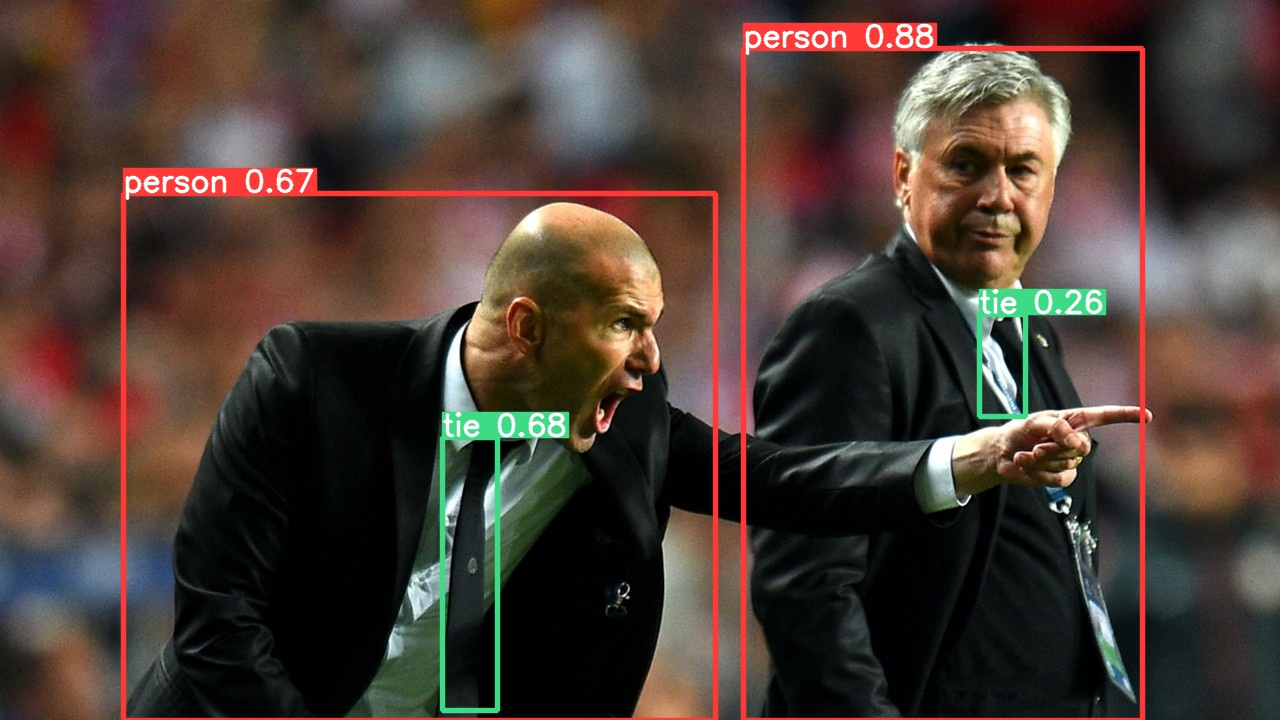

In [8]:
!python detect.py --weights yolov5s.pt --img 640 --conf 0.25 --source data/images
import cv2
from google.colab.patches import cv2_imshow
cv2_imshow(cv2.imread('runs/detect/exp/zidane.jpg'))

이제 훈련을 위한 설정 파일을 준비합니다.

YOLOv5에는 기본적으로 VOC 데이터셋을 훈련하기 위한 VOC.yaml파일이 있습니다만, 저희는 별도로 yaml파일을 제작합니다.

내용은 아래와 같습니다.

YOLOv5는 darknet을 사용하는 이전의 YOLOv4와는 다르게 데이터셋이 있는 폴더 경로를 입력하여서 훈련에 사용할 수 있습니다.

```
train:
  - /content/VOCData/train
val:
  - /content/VOCData/val

# Classes
names:
  0: aeroplane
  1: bicycle
  2: bird
  3: boat
  4: bottle
  5: bus
  6: car
  7: cat
  8: chair
  9: cow
  10: diningtable
  11: dog
  12: horse
  13: motorbike
  14: person
  15: pottedplant
  16: sheep
  17: sofa
  18: train
  19: tvmonitor
```



In [9]:
text_lines = '''
train:
  - /content/VOCData/train
val:
  - /content/VOCData/val

# Classes
names:
  0: aeroplane
  1: bicycle
  2: bird
  3: boat
  4: bottle
  5: bus
  6: car
  7: cat
  8: chair
  9: cow
  10: diningtable
  11: dog
  12: horse
  13: motorbike
  14: person
  15: pottedplant
  16: sheep
  17: sofa
  18: train
  19: tvmonitor
'''
with open("/content/yolov5/vocdata.yaml", 'w') as f:
    f.write(text_lines)

이제 훈련을 수행하겠습니다.

In [10]:
!python train.py --img 480 --batch 16 --epochs 20 --data vocdata.yaml --weights yolov5s.pt --cache

2023-12-06 07:31:06.530386: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 07:31:06.530435: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 07:31:06.530471: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 07:31:07.557807: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
train: weights=yolov5s.pt, cfg=, data=vocdata.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=20, batch_size=16, imgsz=480, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cac

훈련이 완료되면 weight 파일을 다운로드합니다.

In [11]:
from google.colab import files
files.download('/content/yolov5/runs/train/exp/weights/best.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>